In [20]:
import datetime as dt
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import requests
import tabula
from bs4 import BeautifulSoup
from tqdm import tqdm

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]

In [2]:
def fetch_bonds_interest_single_issue(year, month):
    symbol = f'rod{month:02d}{(year + 12) % 100}'
    url = f'https://www.obligacjeskarbowe.pl/oferta-obligacji/obligacje-12-letnie-rod/{symbol}/'
    soup = BeautifulSoup(requests.get(url).text)
    
    cell, = soup.body.findAll(text="Sprzedaż:")
    date_text = cell.parent.find_next_sibling().text
    date_set = set(re.findall(r'\d{2}\.(\d{2})\.(\d{4})', date_text))
    assert date_set == {(f'{month:02d}', str(year))}, date_set
    
    cell, = soup.body.findAll(text="Oprocentowanie:")
    match, = re.findall(
        r'\s+(\d+\,\d+)%\s+w pierwszym .*, w kolejnych.* (\d+\,\d+)% \+ inflacja',
        cell.parent.find_next_sibling().text.replace('\xa0', '')
    )
    return tuple(float(s.replace(',', '.')) for s in match)

def fetch_bonds_interest(count):
    data = []

    date = dt.datetime.now()
    date = dt.datetime(year=date.year, month=date.month, day=1)

    for _ in tqdm(range(count)):
        interest, margin = fetch_bonds_interest_single_issue(date.year, date.month)
        data.append({
            'date': date,
            'interest': interest,
            'margin': margin,
        })
        date -= dt.timedelta(days=1)
        date = dt.datetime(year=date.year, month=date.month, day=1)
    
    df = pd.DataFrame(data).set_index('date')
    df.index = pd.to_datetime(df.index)
    return df

In [3]:
def fetch_nbp_iterest_rates():
    url = 'https://www.nbp.pl/home.aspx?f=/dzienne/stopy_archiwum.htm'
    soup = BeautifulSoup(requests.get(url).text)

    header, = soup.body.findAll(text=f' Podstawowe stopy procentowe NBP w latach 1998-{dt.datetime.now().year}')
    table = header.parent.find_next_sibling("table")
    header_row, *rows = table.findAll('tr')
    header_cells = header_row.findAll('th')

    assert "Obowiązuje od:" in header_cells[0].text, header_cells[0].text
    assert "Stopa referencyjna" in header_cells[1].text, header_cells[1].text

    data = {}
    for row in rows:
        cells = row.findAll('td')
        if len(cells) > 1:
            data[cells[0].text] = float(cells[1].text.replace(',', '.'))
            
    series = pd.Series(data)
    series.index = pd.to_datetime(series.index)
    return series

In [4]:
def fetch_inflation():
    url = "https://stat.gov.pl/download/gfx/portalinformacyjny/pl/defaultstronaopisowa/4741/1/1/miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_r.xlsx"
    raw = pd.read_excel(url)
    return pd.Series({
        dt.datetime(year=row[1]["Rok"], month=row[1]["Miesiąc"], day=1):
            row[1]["Wartość"] - 100
        for row in raw.iterrows()
    })

In [5]:
def fetch_wibor(year, month):
    url = f"https://www.money.pl/pieniadze/depozyty/zlotowearch/{year}-{month}-01,{year}-{month}-07,WIBOR6M,strona,1.html"
    soup = BeautifulSoup(requests.get(url).text)
    try:
        cell, = soup.findAll(text="Kurs wartość [PLN]")
    except:
        return None
    return float(cell.parent.parent.parent.parent.findAll("td")[1].text.replace(',', '.'))

In [6]:
nbp = fetch_nbp_iterest_rates()
bonds = fetch_bonds_interest(60)

100%|███████████████████████████████████████████████████████████████| 60/60 [01:13<00:00,  1.22s/it]


In [7]:
inflation = fetch_inflation()

In [8]:
df = bonds.rename(columns={"interest": "ROD bonds interest", "margin": "ROD bonds margin"})
df = df.assign(**{
    "NBP rates": pd.Series({
        date: nbp[nbp.index.searchsorted(date) - 1]
        for date in df.index
    }),
    "inflation": pd.Series({
        date: inflation[date]
        for date in df.index
    }),
    "WIBOR 6M": pd.Series({
        date: fetch_wibor(date.year, date.month)
        for date in tqdm(df.index, "WIBOR")
    })
})

WIBOR: 100%|████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.54it/s]


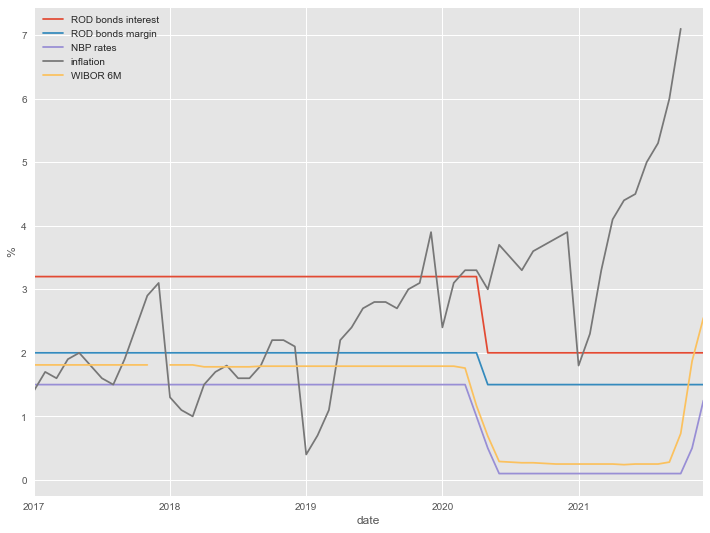

In [29]:
ax = df.plot(ylabel='%')